# DETR Object Detection on TUM RGB-D Image

## Step 1: Install Dependencies

In [2]:
!pip install torch torchvision opencv-python matplotlib requests --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00


In [3]:
import torch
import torchvision.transforms as T
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Step 2: Load Pretrained DETR Model

In [4]:
detr = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
detr.eval()

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

## Step 3: Load COCO Class Labels

In [5]:

# STEP 3: Load COCO Class Labels
CLASSES = [
  'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
  'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench',
  'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
  'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee',
  'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
  'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup',
  'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
  'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
  'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
  'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
  'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


## Step 4: Load and Prepare Image

In [6]:

# STEP 4: Load TUM RGB-D Image via OpenCV
image_url = 'https://cvg.cit.tum.de/rgbd/dataset/freiburg1/rgbd_dataset_freiburg1_xyz.tgz'
!wget {image_url} -O dataset.tgz --quiet
!tar -xzf dataset.tgz

image_path = './rgbd_dataset_freiburg1_xyz/rgb/1305031102.175304.png'
bgr_img = cv2.imread(image_path)
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

# Convert to PIL and resize
im = Image.fromarray(rgb_img)
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])
img_tensor = transform(im).unsqueeze(0)


## Step 5: Run Inference

In [7]:
with torch.no_grad():
    outputs = detr(img_tensor)

## Step 6: Filter Predictions

In [8]:
# Filter with confidence > 0.7
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = out_bbox * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    b[..., :2] -= b[..., 2:] / 2
    b[..., 2:] += b[..., :2]
    return b

probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

## Step 7: Visualize Results

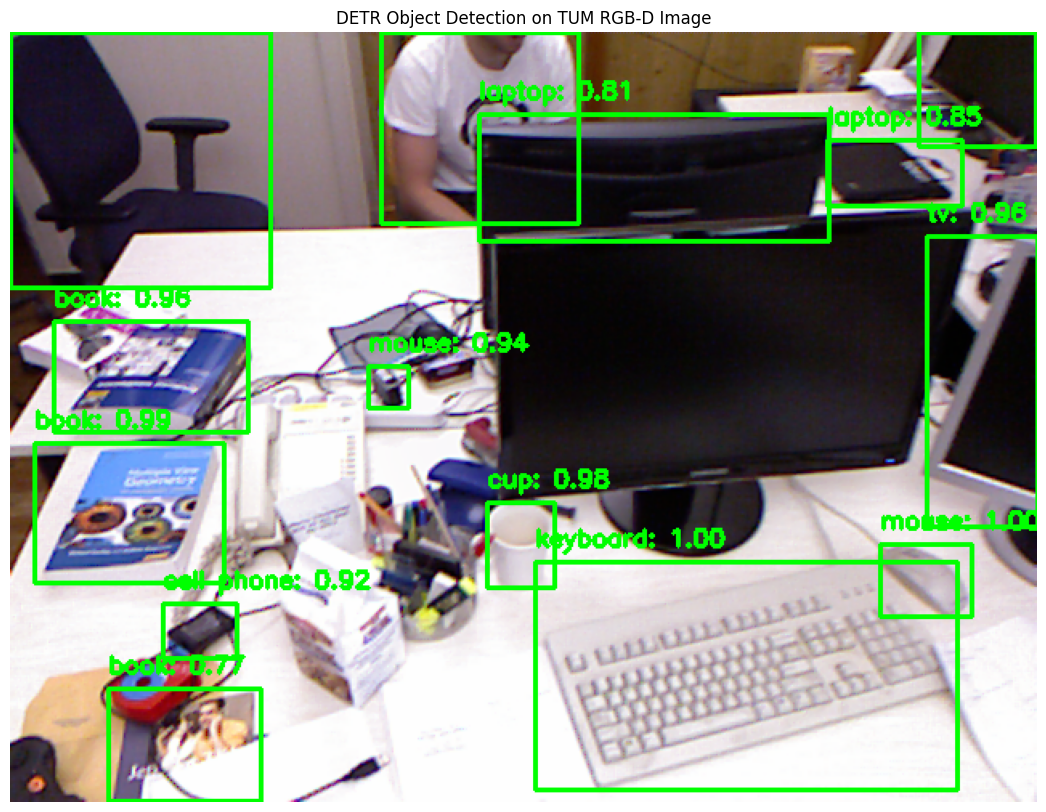

In [9]:
img_np = np.array(im).copy()
for p, box in zip(probas[keep], bboxes_scaled):
    cls = p.argmax()
    label = f'{CLASSES[cls]}: {p[cls]:.2f}'
    color = (0, 255, 0)
    x0, y0, x1, y1 = box.int().tolist()
    cv2.rectangle(img_np, (x0, y0), (x1, y1), color, 2)
    cv2.putText(img_np, label, (x0, y0 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(14, 10))
plt.imshow(img_np)
plt.axis('off')
plt.title('DETR Object Detection on TUM RGB-D Image')
plt.show()